# Preference Learning Report Visualizations

Visualize the new simulation results JSON produced by `run_persona_linear_hx_xai_simulation` (HX-XAI vs AutoXAI baseline).

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

DATASET_LABELS = {
    'open_compas': 'OpenML COMPAS',
    'openml_bank_marketing': 'OpenML Bank Marketing',
    'openml_german_credit': 'OpenML German Credit',
}
MODEL_LABELS = {
    'decision_tree': 'Decision Tree',
    'gradient_boosting': 'Gradient Boosting',
    'logistic_regression': 'Logistic Regression',
    'mlp_classifier': 'Multilayer Perceptron',
}

# Path to either a single simulation JSON or a directory containing multiple JSON files.
RESULTS_PATH = Path('../../results') / 'hc_combo_20251228_050331' / 'preference_learning_simulation_advanced' / 'basic_features/tuned-svc-allmetrics_defaultc' # basic_plus_stat, full_lm_stats, basic_features


# Optional filters.
PERSONA_FILTER: str | None = None  # e.g. 'clinician' / 'regulator' / 'lay_user'
K_TO_PLOT = 3

def _suffix_from_path(path: Path) -> str:
    token = path.parent.name if path.suffix else path.name
    token = token or 'reports'
    return token.replace(' ', '_')

RUN_SUFFIX = _suffix_from_path(RESULTS_PATH)
REPORTS_DIR = (RESULTS_PATH.parent if RESULTS_PATH.suffix else RESULTS_PATH) / 'reports'
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')



In [2]:
def _iter_result_paths(path: Path) -> List[Path]:
    if path.is_dir():
        persona_jsons = list(path.rglob('persona_simulation_summary.json'))
        if persona_jsons:
            return sorted(persona_jsons)
        return sorted(path.rglob('*.json'))
    if path.is_file():
        return [path]
    return []


def load_simulation_results(path: Path = RESULTS_PATH) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for json_path in _iter_result_paths(path):
        payload: Dict[str, Any] = json.loads(json_path.read_text(encoding='utf-8'))
        dataset = payload.get('dataset')
        model = payload.get('model')
        persona = payload.get('persona')
        tau = (
            (payload.get('persona_sampling') or {}).get('tau_override')
            or (payload.get('persona_config') or {}).get('tau')
        )
        if tau is None:
            per_user = payload.get('per_user') or []
            if per_user and isinstance(per_user, list) and isinstance(per_user[0], dict):
                tau = per_user[0].get('tau')
        try:
            tau = float(tau) if tau is not None else None
        except Exception:
            tau = None

        for method, key in (
            ('PersoXAI', 'aggregate_top_k_mean'),
            ('autoxai', 'aggregate_autoxai_top_k_mean'),
        ):
            top_k = payload.get(key) or {}
            for k, stats in top_k.items():
                try:
                    k_int = int(k)
                except Exception:
                    continue
                spearman = 0.0
                if isinstance(stats, dict):
                    rank_corr = stats.get('rank_correlation')
                    if isinstance(rank_corr, dict):
                        spearman = float(rank_corr.get('spearman') or 0.0)
                    else:
                        spearman = float(stats.get('rank_correlation.spearman') or 0.0)
                records.append(
                    {
                        'file': json_path.name,
                        'dataset': dataset,
                        'model': model,
                        'persona': persona,
                        'tau': tau,
                        'method': method,
                        'k': k_int,
                        'precision': float((stats or {}).get('precision', 0.0)),
                        'recall': float((stats or {}).get('recall', 0.0)),
                        'jaccard': float((stats or {}).get('jaccard', 0.0)),
                        'spearman': spearman,
                    }
                )
    df = pd.DataFrame(records)
    if df.empty:
        print(f'No simulation results found under: {path.resolve()}')
        return df
    print(f'Loaded {len(df)} rows from {df["file"].nunique()} JSON file(s).')
    return df


results_df = load_simulation_results()
results_df.head()


Loaded 216 rows from 36 JSON file(s).


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,PersoXAI,3,0.974167,0.974167,0.961250,0.842750
1,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,PersoXAI,5,0.970500,0.970500,0.951190,0.944107
2,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,PersoXAI,8,0.981875,0.981875,0.967889,0.972143
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,autoxai,3,0.743333,0.743333,0.658625,0.499214
4,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,autoxai,5,0.771750,0.771750,0.660585,0.513753


In [3]:
# Inspect encoded dataset sizes referenced by the simulation results.
ENCODED_BASE_DIR = Path('../../results/full_run_dec8/encoded_pareto_fronts/features_full_lm_stats').resolve()
encoded_paths_raw = []
for json_path in _iter_result_paths(RESULTS_PATH):
    payload = json.loads(json_path.read_text(encoding='utf-8'))
    encoded_path_val = payload.get('encoded_path')
    if encoded_path_val:
        encoded_paths_raw.append(encoded_path_val)

def _resolve_encoded_path(path_str: str) -> Path:
    path = Path(path_str)
    candidates = [
        path,
        Path.cwd() / path,
        RESULTS_PATH.parent / path,
        ENCODED_BASE_DIR / path.name,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return path

encoded_paths = sorted({str(_resolve_encoded_path(p)) for p in encoded_paths_raw})
encoded_stats_rows: list[dict[str, object]] = []
for raw_path in encoded_paths:
    resolved = Path(raw_path)
    exists = resolved.exists()
    rows = None
    cols = None
    error = None
    if exists:
        try:
            df = pd.read_parquet(resolved)
            rows = len(df)
            cols = len(df.columns)
        except Exception as exc:  # pragma: no cover - notebook debug helper
            error = str(exc)
    encoded_stats_rows.append(
        {
            'encoded_path': str(resolved),
            'exists': bool(exists),
            'rows': rows,
            'columns': cols,
            'error': error,
        }
    )

encoded_stats_df = pd.DataFrame(encoded_stats_rows)
print(f'Found {len(encoded_paths)} encoded file(s) referenced in results.')
encoded_stats_df


Found 12 encoded file(s) referenced in results.


,encoded_path,exists,rows,columns,error
0,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,467,73,None
1,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,473,73,None
2,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,500,73,None
3,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,505,73,None
4,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,387,73,None
5,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,505,73,None
6,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,527,73,None
7,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,558,73,None
8,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,418,73,None
9,/home/kelemnegasi/workspace/xai/hc-xai-project...,True,523,73,None


In [4]:
# Preview column names and example values from the first available encoded file.
if encoded_paths:
    preview_path = _resolve_encoded_path(encoded_paths[0])
else:
    preview_path = None

if preview_path and preview_path.exists():
    encoded_preview_df = pd.read_parquet(preview_path)
    print(f'Previewing encoded file: {preview_path}')
    print(f'Rows: {len(encoded_preview_df):,} | Columns: {len(encoded_preview_df.columns):,}')
    column_preview = pd.DataFrame(
        {
            'column': encoded_preview_df.columns,
            'example_value': encoded_preview_df.iloc[0].astype(str).tolist() if not encoded_preview_df.empty else [],
        }
    )
    display(column_preview.head(50))
    display(encoded_preview_df.head())
else:
    print('No encoded file available to preview (check RESULTS_PATH and encoded_path in results).')


Previewing encoded file: /home/kelemnegasi/workspace/xai/hc-xai-project/hc-xai/results/full_run_dec8/encoded_pareto_fronts/features_full_lm_stats/open_compas__decision_tree_pareto_encoded.parquet
Rows: 467 | Columns: 73


,column,example_value
0,dataset,open_compas
1,model,decision_tree
2,instance_index,91
3,method,causal_shap
4,method_variant,causal_shap__causal_shap_coalitions-40
5,dataset_id_oh_0,1
6,dataset_id_oh_1,0
7,dataset_id_oh_2,0
8,dataset_log_feature_count_z,-1.411888045039296
9,dataset_class_entropy_z,0.9657972281012779


,dataset,model,instance_index,method,method_variant,dataset_id_oh_0,dataset_id_oh_1,dataset_id_oh_2,dataset_log_feature_count_z,dataset_class_entropy_z,...,correctness,covariate_complexity,covariate_regularity,infidelity,monotonicity,non_sensitivity_delta_mean,non_sensitivity_safe_fraction,non_sensitivity_violation_fraction,non_sensitivity_zero_features,relative_input_stability
0,open_compas,decision_tree,91,causal_shap,causal_shap__causal_shap_coalitions-40,1,0,0,-1.411888,0.965797,...,0.0,2.709835,2.709835,0.698548,-0.745356,-3.000000,0.0,-3.000000,3.000000,0.916666
1,open_compas,decision_tree,91,lime,lime__lime_kernel_width-1.5__lime_num_samples-100,1,0,0,-1.411888,0.965797,...,0.0,0.366226,0.366226,0.593275,0.745356,0.333333,0.0,0.333333,-0.333333,-1.758544
2,open_compas,decision_tree,91,lime,lime__lime_kernel_width-1.5__lime_num_samples-200,1,0,0,-1.411888,0.965797,...,0.0,0.001640,0.001640,0.559032,0.745356,0.333333,0.0,0.333333,-0.333333,-0.847124
3,open_compas,decision_tree,91,lime,lime__lime_kernel_width-2.0__lime_num_samples-100,1,0,0,-1.411888,0.965797,...,0.0,-0.344209,-0.344209,0.525250,0.745356,0.333333,0.0,0.333333,-0.333333,0.256830
4,open_compas,decision_tree,91,lime,lime__lime_kernel_width-2.0__lime_num_samples-200,1,0,0,-1.411888,0.965797,...,0.0,0.008830,0.008830,0.530092,0.745356,0.333333,0.0,0.333333,-0.333333,-1.629687


In [5]:
def _format_label(name: object) -> str:
    if not isinstance(name, str) or not name:
        return 'Unknown'
    return name.replace('_', ' ').title()

if not results_df.empty:
    results_df['dataset_label'] = results_df['dataset'].map(DATASET_LABELS).fillna(results_df['dataset'].apply(_format_label))
    results_df['model_label'] = results_df['model'].map(MODEL_LABELS).fillna(results_df['model'].apply(_format_label))
    if PERSONA_FILTER is not None:
        results_df = results_df[results_df['persona'] == PERSONA_FILTER].copy()

plot_df = results_df[results_df['k'] == int(K_TO_PLOT)].copy() if not results_df.empty else results_df
plot_df.head()


,file,dataset,model,persona,tau,method,k,precision,recall,jaccard,spearman,dataset_label,model_label
0,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,PersoXAI,3,0.974167,0.974167,0.961250,0.842750,OpenML COMPAS,Decision Tree
3,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,clinician,0.01,autoxai,3,0.743333,0.743333,0.658625,0.499214,OpenML COMPAS,Decision Tree
6,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,lay,0.01,PersoXAI,3,0.969583,0.969583,0.954375,0.852750,OpenML COMPAS,Decision Tree
9,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,lay,0.01,autoxai,3,0.717917,0.717917,0.624625,0.441304,OpenML COMPAS,Decision Tree
12,persona_simulation_summary__open_compas__decis...,open_compas,decision_tree,regulator,0.01,PersoXAI,3,0.977083,0.977083,0.965625,0.861875,OpenML COMPAS,Decision Tree


In [6]:
summary_df = (
    plot_df
    .groupby(['dataset', 'dataset_label', 'model', 'model_label', 'persona', 'method', 'k'])
    [['precision', 'recall', 'jaccard']]
    .mean()
    .reset_index()
)
if not summary_df.empty:
    file_base = f"summary_all_datasets_all_models_k{int(K_TO_PLOT)}_{RUN_SUFFIX}"
    summary_df.to_csv(REPORTS_DIR / f"{file_base}.csv", index=False)
summary_df

,dataset,dataset_label,model,model_label,persona,method,k,precision,recall,jaccard
0,open_compas,OpenML COMPAS,decision_tree,Decision Tree,clinician,PersoXAI,3,0.974167,0.974167,0.961250
1,open_compas,OpenML COMPAS,decision_tree,Decision Tree,clinician,autoxai,3,0.743333,0.743333,0.658625
2,open_compas,OpenML COMPAS,decision_tree,Decision Tree,lay,PersoXAI,3,0.969583,0.969583,0.954375
3,open_compas,OpenML COMPAS,decision_tree,Decision Tree,lay,autoxai,3,0.717917,0.717917,0.624625
4,open_compas,OpenML COMPAS,decision_tree,Decision Tree,regulator,PersoXAI,3,0.977083,0.977083,0.965625
...,...,...,...,...,...,...,...,...,...,...
67,openml_german_credit,OpenML German Credit,mlp_classifier,Multilayer Perceptron,clinician,autoxai,3,0.712083,0.712083,0.601625
68,openml_german_credit,OpenML German Credit,mlp_classifier,Multilayer Perceptron,lay,PersoXAI,3,0.961667,0.961667,0.942500
69,openml_german_credit,OpenML German Credit,mlp_classifier,Multilayer Perceptron,lay,autoxai,3,0.795417,0.795417,0.710125
70,openml_german_credit,OpenML German Credit,mlp_classifier,Multilayer Perceptron,regulator,PersoXAI,3,0.956250,0.956250,0.934375


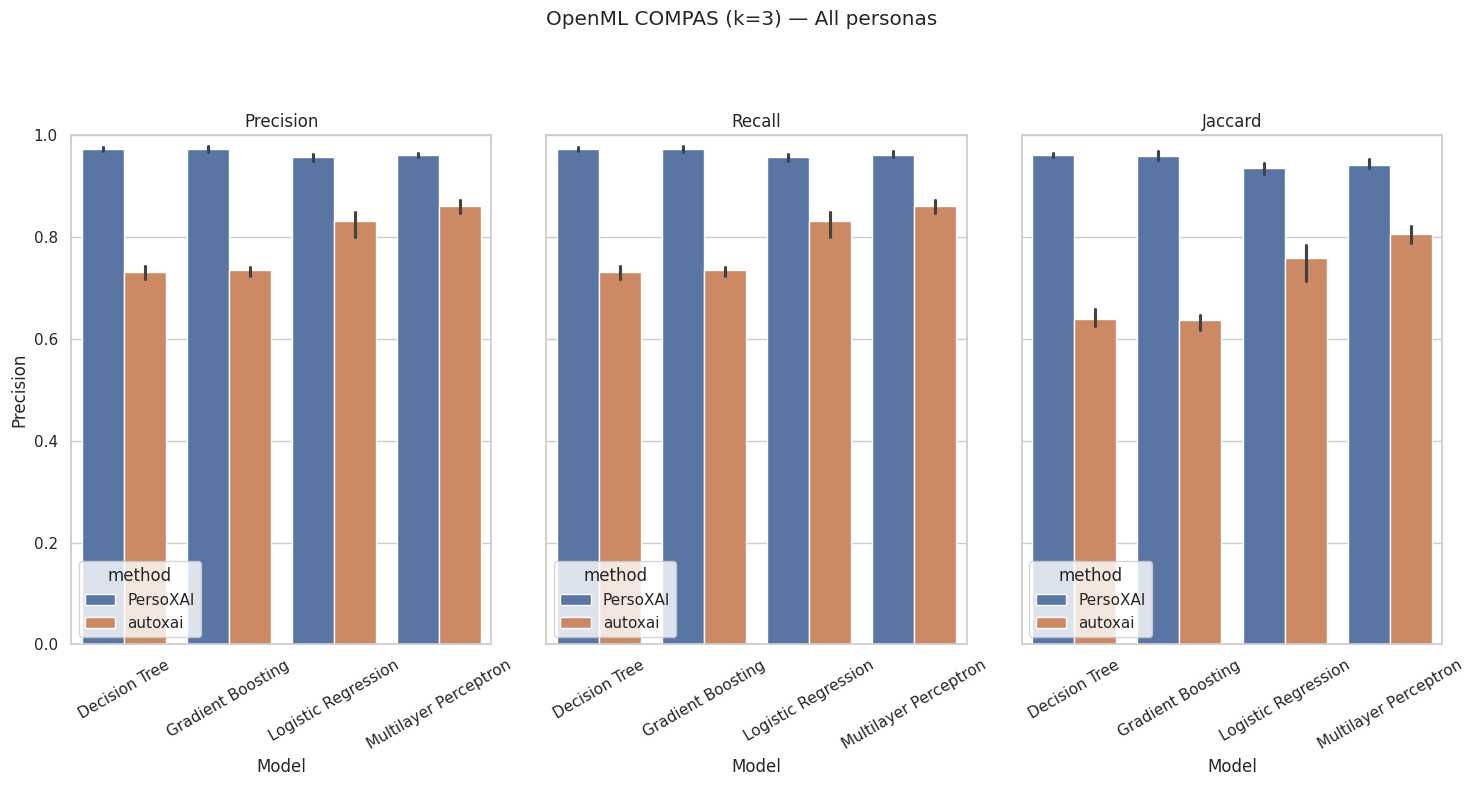

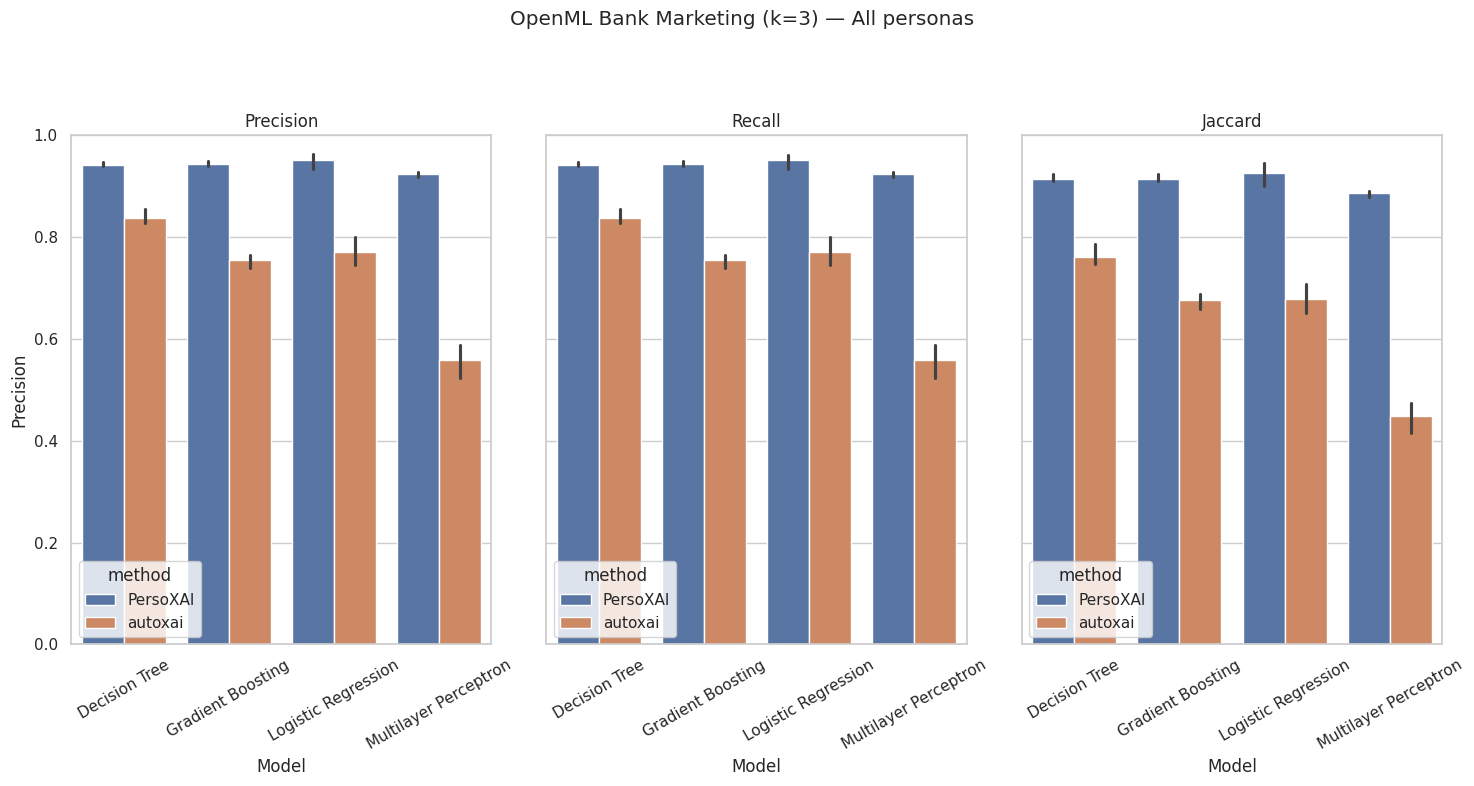

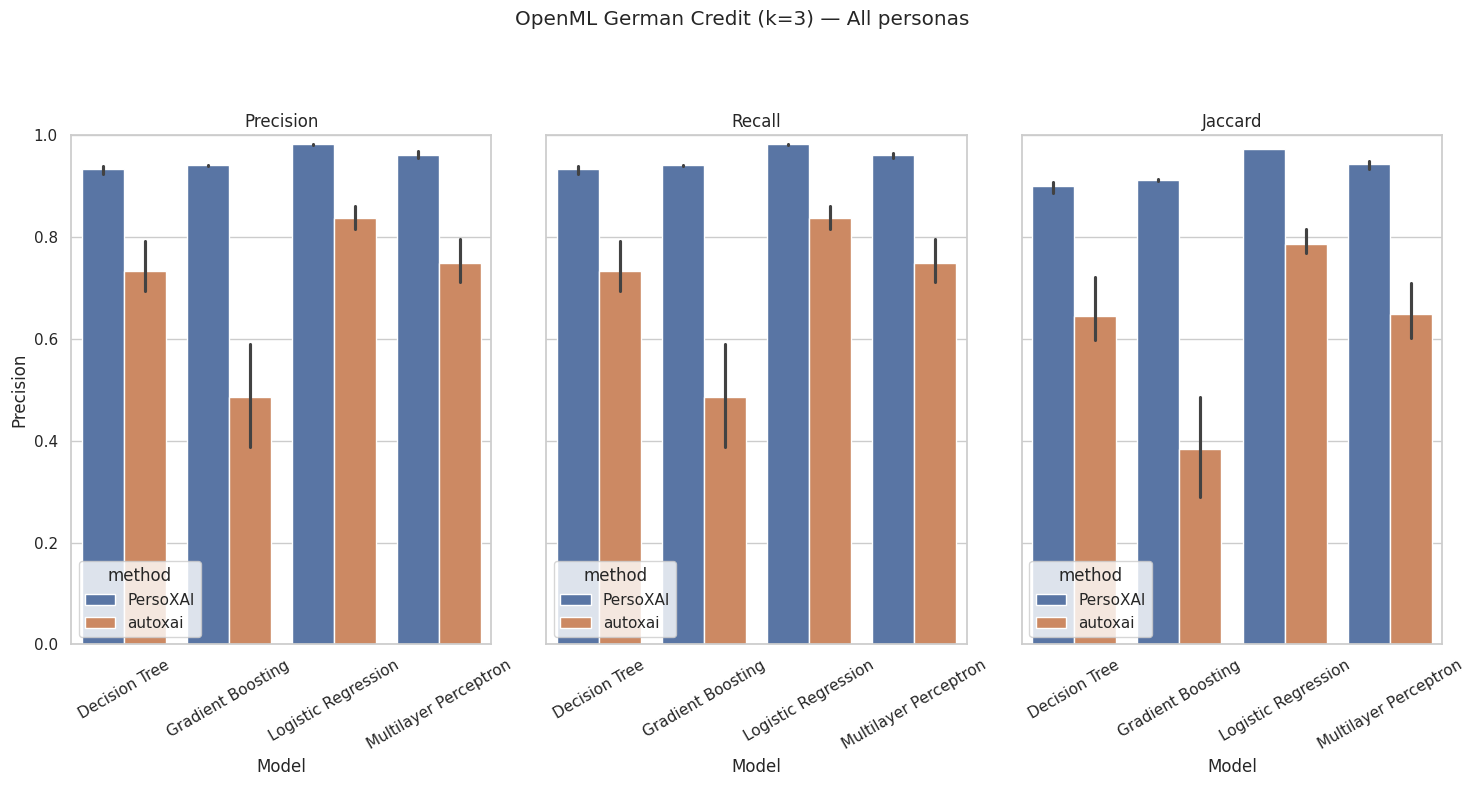

In [7]:
def plot_bars_by_dataset(df: pd.DataFrame) -> None:
    if df.empty:
        print('No rows to plot (check RESULTS_PATH / PERSONA_FILTER / K_TO_PLOT).')
        return

    model_order = [MODEL_LABELS[key] for key in MODEL_LABELS if (df['model'] == key).any()]
    for dataset_key, subset in df.groupby('dataset', sort=True):
        dataset_label = subset['dataset_label'].iloc[0]
        fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)
        for ax, metric in zip(axes, ['precision', 'recall', 'jaccard']):
            sns.barplot(
                data=subset,
                x='model_label',
                y=metric,
                hue='method',
                order=model_order if model_order else None,
                ax=ax,
            )
            ax.set_title(metric.title())
            ax.set_xlabel('Model')
            ax.set_ylabel(metric.title())
            ax.set_ylim(0, 1)
            ax.tick_params(axis='x', rotation=30)
        persona_title = f"Persona={PERSONA_FILTER}" if PERSONA_FILTER else 'All personas'
        fig.suptitle(f'{dataset_label} (k={int(K_TO_PLOT)}) — {persona_title}')
        fig.tight_layout(rect=[0, 0, 1, 0.92])
        file_base = f"bars_{dataset_key}_all_models_precision_recall_jaccard_k{int(K_TO_PLOT)}_{RUN_SUFFIX}"
        fig.savefig(REPORTS_DIR / f"{file_base}.png", dpi=300, bbox_inches='tight')
        fig.savefig(REPORTS_DIR / f"{file_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
        plt.show()
        plt.close(fig)


plot_bars_by_dataset(summary_df)



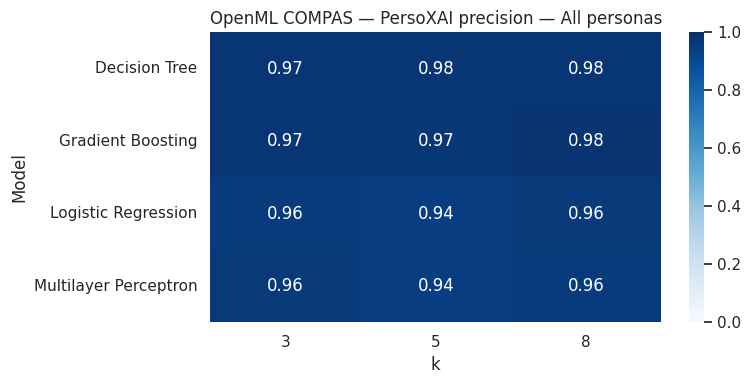

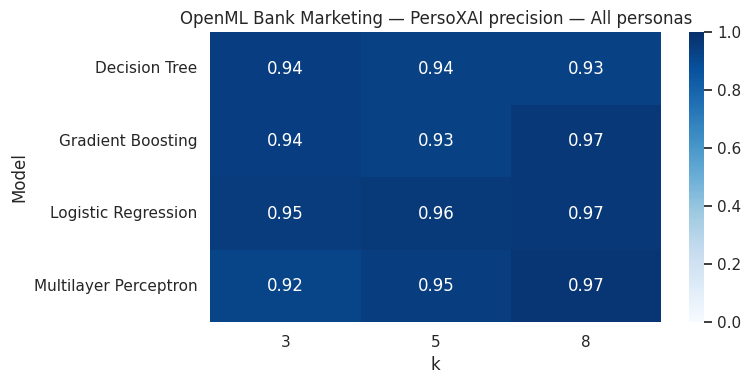

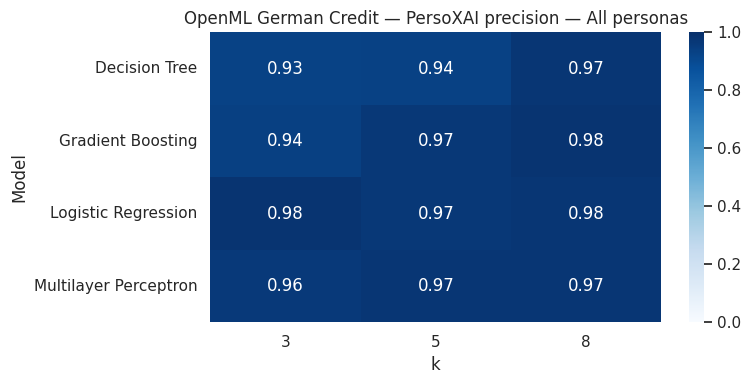

In [8]:
HEATMAP_METHOD = 'PersoXAI'  # 'hx_xai' or 'autoxai'
HEATMAP_METRIC = 'precision'  # 'precision' / 'recall' / 'jaccard'

heatmap_source = results_df.copy()
if PERSONA_FILTER is not None and not heatmap_source.empty:
    heatmap_source = heatmap_source[heatmap_source['persona'] == PERSONA_FILTER].copy()
if not heatmap_source.empty:
    heatmap_source['dataset_label'] = heatmap_source['dataset'].map(DATASET_LABELS).fillna(heatmap_source['dataset'].apply(_format_label))
    heatmap_source['model_label'] = heatmap_source['model'].map(MODEL_LABELS).fillna(heatmap_source['model'].apply(_format_label))

for dataset_key, subset in heatmap_source[heatmap_source['method'] == HEATMAP_METHOD].groupby('dataset', sort=True):
    dataset_label = subset['dataset_label'].iloc[0]
    pivot = subset.pivot_table(index='model_label', columns='k', values=HEATMAP_METRIC, aggfunc='mean')
    if pivot.empty:
        continue
    pivot = pivot.reindex(columns=sorted(pivot.columns))
    fig, ax = plt.subplots(figsize=(8, max(4, 0.6 * len(pivot))))
    sns.heatmap(pivot, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='Blues', ax=ax)
    persona_title = f"Persona={PERSONA_FILTER}" if PERSONA_FILTER else 'All personas'
    ax.set_title(f'{dataset_label} — {HEATMAP_METHOD} {HEATMAP_METRIC} — {persona_title}')
    ax.set_xlabel('k')
    ax.set_ylabel('Model')
    fig.tight_layout()
    file_base = f"heatmap_{dataset_key}_all_models_{HEATMAP_METHOD}_{HEATMAP_METRIC}_{RUN_SUFFIX}"
    fig.savefig(REPORTS_DIR / f"{file_base}.png", dpi=300, bbox_inches='tight')
    fig.savefig(REPORTS_DIR / f"{file_base}.pdf", dpi=300, bbox_inches='tight', format='pdf')
    pivot.to_csv(REPORTS_DIR / f"{file_base}.csv")
    plt.show()
    plt.close(fig)

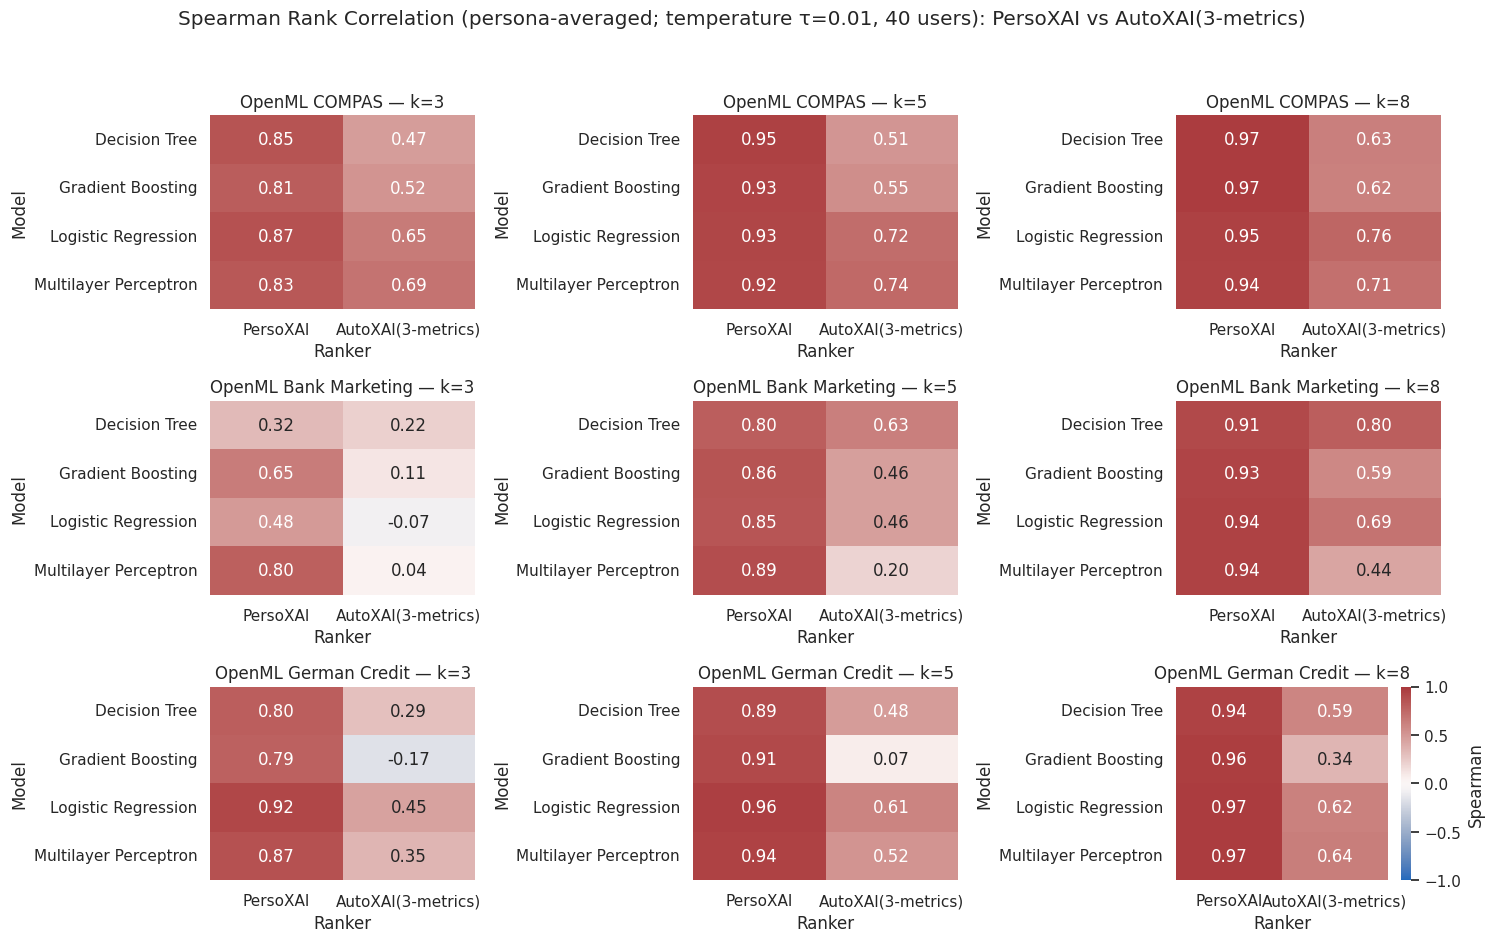

In [9]:
# Spearman heatmaps (persona-averaged): HX-XAI (Ours) vs AutoXAI

K_VALUES = [3, 5, 8]
DATASETS_TO_PLOT = ['open_compas', 'openml_bank_marketing', 'openml_german_credit']

ranker_labels = {
    'perso_xai': 'PersoXAI',
    'autoxai': 'AutoXAI(3-metrics)',
}

spearman_source = results_df.copy()
if spearman_source.empty:
    print('No results loaded (check RESULTS_PATH).')
else:
    spearman_df = (
        spearman_source[spearman_source['k'].isin(K_VALUES)]
        .groupby(['persona', 'dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
        .groupby(['dataset', 'model', 'method', 'k'])['spearman']
        .mean()
        .reset_index()
    )

    spearman_df['dataset_label'] = (
        spearman_df['dataset']
        .map(DATASET_LABELS)
        .fillna(spearman_df['dataset'].apply(_format_label))
    )
    spearman_df['model_label'] = (
        spearman_df['model']
        .map(MODEL_LABELS)
        .fillna(spearman_df['model'].apply(_format_label))
    )

    tau_values = []
    if 'tau' in spearman_source.columns:
        tau_values = [v for v in spearman_source['tau'].dropna().unique().tolist() if v is not None]
    tau_values = sorted(set(float(v) for v in tau_values))
    if len(tau_values) == 1:
        temperature_title = f"τ={tau_values[0]:g}"
    elif len(tau_values) == 0:
        temperature_title = 'τ=?'
    else:
        temperature_title = f"τ∈[{min(tau_values):g}, {max(tau_values):g}]"

    datasets = [d for d in DATASETS_TO_PLOT if (spearman_df['dataset'] == d).any()]
    if not datasets:
        datasets = sorted(spearman_df['dataset'].dropna().unique().tolist())

    n_rows = len(datasets)
    n_cols = len(K_VALUES)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.2 * n_rows), squeeze=False)

    for row_idx, dataset_key in enumerate(datasets):
        dataset_label = DATASET_LABELS.get(dataset_key, _format_label(dataset_key))
        for col_idx, k in enumerate(K_VALUES):
            ax = axes[row_idx][col_idx]
            subset = spearman_df[(spearman_df['dataset'] == dataset_key) & (spearman_df['k'] == int(k))].copy()
            if subset.empty:
                ax.axis('off')
                continue

            pivot_table = (
                subset
                .pivot_table(index='model_label', columns='method', values='spearman', aggfunc='mean')
                .rename(columns=ranker_labels)
            )

            desired_cols = [ranker_labels['perso_xai'], ranker_labels['autoxai']]
            pivot_table = pivot_table.reindex(columns=[c for c in desired_cols if c in pivot_table.columns])

            present_models = set(subset['model'])
            model_order = [
                MODEL_LABELS.get(model_key, _format_label(model_key))
                for model_key in MODEL_LABELS
                if model_key in present_models
            ]
            if model_order:
                pivot_table = pivot_table.reindex(model_order)

            mask = pivot_table.isna()
            sns.heatmap(
                pivot_table,
                annot=True,
                fmt='.2f',
                cmap='vlag',
                vmin=-1,
                vmax=1,
                mask=mask,
                ax=ax,
                cbar=(row_idx == n_rows - 1 and col_idx == n_cols - 1),
                cbar_kws={'label': 'Spearman'} if (row_idx == n_rows - 1 and col_idx == n_cols - 1) else None,
            )
            ax.set_title(f"{dataset_label} — k={k}")
            ax.set_xlabel('Ranker')
            ax.set_ylabel('Model')

    fig.suptitle(
        f"Spearman Rank Correlation (persona-averaged; temperature {temperature_title}, 40 users): "
        f"{ranker_labels['perso_xai']} vs {ranker_labels['autoxai']}"
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    spearman_fig = REPORTS_DIR / f"spearman_heatmaps_all_datasets_all_models_{RUN_SUFFIX}.png"
    fig.savefig(spearman_fig, dpi=300, bbox_inches='tight')
    spearman_fig = REPORTS_DIR / f"spearman_heatmaps_all_datasets_all_models_{RUN_SUFFIX}.pdf"
    fig.savefig(spearman_fig, dpi=300, bbox_inches='tight', format='pdf')
    spearman_df.to_csv(REPORTS_DIR / f"spearman_heatmap_values_all_datasets_all_models_{RUN_SUFFIX}.csv", index=False)
    plt.show()
    plt.close(fig)



In [ ]:
# Tau sweep summary: plot τ vs aggregated Spearman.
# Point this to the folder/file produced by `python -m src.preference_learning.run_all --tau-values ...`.

# Common locations:
# - (RESULTS_PATH)/tau_tuning/tau_tunning_summary.json  (if you ran with --tau-results-dir under RESULTS_PATH)
# - ../../preference-learning-simulation/basic-features/tau-tunning-results/tau_tunning_summary.json (default)


TAU_SWEEP_RESULTS_PATH = Path('../../results') / 'full_run_dec8' / 'preference_learning_simulation' / 'basic_features/' / 'untuned-svc' / 'tau_tunning'

def _find_tau_sweep_summary(path: Path) -> Path | None:
    candidates = [path, TAU_SWEEP_RESULTS_PATH]
    for base in candidates:
        if base.is_dir():
            for name in ('tau_tunning_summary.json', 'tau_tunning_summary.csv'):
                candidate = base / name
                if candidate.exists():
                    return candidate
        elif base.is_file() and base.name in {'tau_tunning_summary.json', 'tau_tunning_summary.csv'}:
            return base

    search_root = path if path.is_dir() else path.parent
    hits = list(search_root.rglob('tau_tunning_summary.json'))
    return hits[0] if hits else None


summary_path = _find_tau_sweep_summary(TAU_SWEEP_RESULTS_PATH)
if summary_path is None:
    print('No tau sweep summary found. Update TAU_SWEEP_RESULTS_PATH or FALLBACK_TAU_SWEEP_RESULTS_PATH.')
else:
    if summary_path.suffix == '.csv':
        tau_summary_df = pd.read_csv(summary_path)
        best_tau = float(tau_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['tau'])
        best_value = float(tau_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['aggregate_spearman'])
    else:
        payload = json.loads(summary_path.read_text(encoding='utf-8'))
        tau_summary_df = pd.DataFrame(payload.get('results') or [])
        best_tau = float(payload.get('best_tau')) if payload.get('best_tau') is not None else float('nan')
        best_value = float(payload.get('best_aggregate_spearman')) if payload.get('best_aggregate_spearman') is not None else float('nan')
        if pd.isna(best_tau) and not tau_summary_df.empty:
            best_row = tau_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]
            best_tau = float(best_row['tau'])
            best_value = float(best_row['aggregate_spearman'])

    if tau_summary_df.empty:
        print(f'No tau sweep rows found in: {summary_path}')
    else:
        tau_summary_df = tau_summary_df.copy()
        tau_summary_df['tau'] = pd.to_numeric(tau_summary_df['tau'], errors='coerce')
        tau_summary_df['aggregate_spearman'] = pd.to_numeric(tau_summary_df['aggregate_spearman'], errors='coerce')
        tau_summary_df = tau_summary_df.dropna(subset=['tau', 'aggregate_spearman']).sort_values('tau')
        display(tau_summary_df)

        fig, ax = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=tau_summary_df, x='tau', y='aggregate_spearman', marker='o', ax=ax)
        if not pd.isna(best_tau):
            ax.axvline(best_tau, color='tab:red', linestyle='--', linewidth=1, alpha=0.6)
            ax.scatter([best_tau], [best_value], color='tab:red', zorder=5)
            ax.annotate(
                f'best τ={best_tau:g}\nSpearman={best_value:.3f}',
                xy=(best_tau, best_value),
                xycoords='data',
                xytext=(0.6, 0.90),
                textcoords='axes fraction',
                ha='right',
                va='top',
                arrowprops={'arrowstyle': '->', 'color': 'tab:red', 'alpha': 0.6},
                bbox={'boxstyle': 'round,pad=0.25', 'fc': 'white', 'ec': '0.8', 'alpha': 0.9},
            )

        ax.set_title('Effect of preference temperature τ on aggregated Spearman')
        ax.set_xlabel('τ (temperature)')
        ax.set_ylabel('Aggregated Spearman (mean across runs and k)')
        ax.grid(True, which='both', axis='both', alpha=0.2)
        fig.tight_layout()

        out_base = f'tau_sweep_spearman_{RUN_SUFFIX}'
        fig.savefig(REPORTS_DIR / f'{out_base}.png', dpi=300, bbox_inches='tight')
        tau_summary_df.to_csv(REPORTS_DIR / f'{out_base}.csv', index=False)
        plt.show()
        plt.close(fig)


In [ ]:
# Num-users sweep summary: plot num_users vs aggregated Spearman.
# Point this to the folder/file produced by `python -m src.preference_learning.run_all --num-users-values ...`.

# Common locations:
# - (RESULTS_PATH)/num_users_sweep/num_users_sweep_summary.json  (if you ran with --num-users-results-dir under RESULTS_PATH)
# - ../../preference-learning-simulation/basic-features/num-users-sweep-results/num_users_sweep_summary.json (default)


NUM_USERS_SWEEP_RESULTS_PATH = (
    Path('../../results')
    / 'full_run_dec8'
    / 'preference_learning_simulation'
    / 'basic_features/'
    / 'untuned-svc'
    / 'num_users_sweep'
)


def _find_num_users_sweep_summary(path: Path) -> Path | None:
    candidates = [path, NUM_USERS_SWEEP_RESULTS_PATH]
    for base in candidates:
        if base.is_dir():
            for name in ('num_users_sweep_summary.json', 'num_users_sweep_summary.csv'):
                candidate = base / name
                if candidate.exists():
                    return candidate
        elif base.is_file() and base.name in {'num_users_sweep_summary.json', 'num_users_sweep_summary.csv'}:
            return base

    search_root = path if path.is_dir() else path.parent
    hits = list(search_root.rglob('num_users_sweep_summary.json'))
    return hits[0] if hits else None


summary_path = _find_num_users_sweep_summary(NUM_USERS_SWEEP_RESULTS_PATH)
if summary_path is None:
    print('No num-users sweep summary found. Update NUM_USERS_SWEEP_RESULTS_PATH.')
else:
    if summary_path.suffix == '.csv':
        num_users_summary_df = pd.read_csv(summary_path)
        best_num_users = int(
            num_users_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['num_users']
        )
        best_value = float(
            num_users_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]['aggregate_spearman']
        )
    else:
        payload = json.loads(summary_path.read_text(encoding='utf-8'))
        num_users_summary_df = pd.DataFrame(payload.get('results') or [])
        best_num_users = (
            int(payload.get('best_num_users'))
            if payload.get('best_num_users') is not None
            else -1
        )
        best_value = (
            float(payload.get('best_aggregate_spearman'))
            if payload.get('best_aggregate_spearman') is not None
            else float('nan')
        )
        if best_num_users < 0 and not num_users_summary_df.empty:
            best_row = num_users_summary_df.sort_values('aggregate_spearman', ascending=False).iloc[0]
            best_num_users = int(best_row['num_users'])
            best_value = float(best_row['aggregate_spearman'])

    if num_users_summary_df.empty:
        print(f'No num-users sweep rows found in: {summary_path}')
    else:
        num_users_summary_df = num_users_summary_df.copy()
        num_users_summary_df['num_users'] = pd.to_numeric(num_users_summary_df['num_users'], errors='coerce')
        num_users_summary_df['aggregate_spearman'] = pd.to_numeric(
            num_users_summary_df['aggregate_spearman'], errors='coerce'
        )
        num_users_summary_df = (
            num_users_summary_df.dropna(subset=['num_users', 'aggregate_spearman'])
            .sort_values('num_users')
        )
        display(num_users_summary_df)

        fig, ax = plt.subplots(figsize=(12, 8))
        sns.lineplot(data=num_users_summary_df, x='num_users', y='aggregate_spearman', marker='o', ax=ax)
        if best_num_users >= 1 and not pd.isna(best_value):
            ax.axvline(best_num_users, color='tab:red', linestyle='--', linewidth=1, alpha=0.6)
            ax.scatter([best_num_users], [best_value], color='tab:red', zorder=5)
            ax.annotate(
                f'best users={best_num_users}\nSpearman={best_value:.3f}',
                xy=(best_num_users, best_value),
                xycoords='data',
                xytext=(0.6, 0.90),
                textcoords='axes fraction',
                ha='right',
                va='top',
                arrowprops={'arrowstyle': '->', 'color': 'tab:red', 'alpha': 0.6},
                bbox={'boxstyle': 'round,pad=0.25', 'fc': 'white', 'ec': '0.8', 'alpha': 0.9},
            )

        ax.set_title('Effect of number of users on aggregated Spearman')
        ax.set_xlabel('num_users')
        ax.set_ylabel('Aggregated Spearman (mean across runs and k)')
        ax.grid(True, which='both', axis='both', alpha=0.2)
        fig.tight_layout()

        out_base = f'num_users_sweep_spearman_{RUN_SUFFIX}'
        fig.savefig(REPORTS_DIR / f'{out_base}.png', dpi=300, bbox_inches='tight')
        num_users_summary_df.to_csv(REPORTS_DIR / f'{out_base}.csv', index=False)
        plt.show()
        plt.close(fig)
